# Entrainement des modèles
Ce notebook va d'abord optimiser les hyper paramètre du gradient boosting (`xgboost`). Ces paramètres sont ensuite utilisés pour entrainer les modèles sur toutes les données et réaliser la prédiction du 11 au 16 décembre 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta, time

In [2]:
from preprocess.prepare_data import generate_data, get_covid_data, interpolate_covid_data

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [35]:
data_folder = "../data/final_data"
covid_path = "../data/covid_data/OxCGRT_latest.csv"
holidays_path = "../data/data_holidays"

In [39]:
data_convention = pd.read_csv(
    os.path.join(data_folder, 'final_convention.csv'),
    sep=";", index_col=0)
data_champs = pd.read_csv(
    os.path.join(data_folder, 'final_champs.csv'),
    sep=";", index_col=0)
data_peres = pd.read_csv(
    os.path.join(data_folder, 'final_peres.csv'),
    sep=";", index_col=0)
data_convention.tail()

,Débit horaire,Taux d'occupation,datetime,year,month,day,hour,dayofweek,Date,C1_School closing,...,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,StringencyLegacyIndexForDisplay,ContainmentHealthIndexForDisplay,nom_jour_ferie,jour_ferie,nom_vacance_scolaire,vacance_scolaire
9736,847.0,4.82889,2020-12-10 19:00:00+00:00,2020,12,10,19,3,2020-12-10,2.0,...,4.0,0.0,2.0,2.0,75.0,74.04,11,0,4,0
9737,682.0,3.97445,2020-12-10 20:00:00+00:00,2020,12,10,20,3,2020-12-10,2.0,...,4.0,0.0,2.0,2.0,75.0,74.04,11,0,4,0
9738,450.0,2.30889,2020-12-10 21:00:00+00:00,2020,12,10,21,3,2020-12-10,2.0,...,4.0,0.0,2.0,2.0,75.0,74.04,11,0,4,0
9739,278.0,1.68722,2020-12-10 22:00:00+00:00,2020,12,10,22,3,2020-12-10,2.0,...,4.0,0.0,2.0,2.0,75.0,74.04,11,0,4,0
9740,245.0,1.56945,2020-12-10 23:00:00+00:00,2020,12,10,23,3,2020-12-10,2.0,...,4.0,0.0,2.0,2.0,75.0,74.04,11,0,4,0


In [40]:
# Définition du domaine des hyper paramètres
space = {
        'learning_rate':hp.uniform('learning_rate', 0.05,0.31),
        'max_depth':hp.choice('max_depth', np.arange(5, 16, 1, dtype=int)),
        'min_child_weight':hp.choice('min_child_weight', np.arange(1, 20, 1, dtype=int)),
        'colsample_bytree':hp.uniform('colsample_bytree', 0.3, 0.8),
        'n_estimators':hp.choice('n_estimators', np.arange(100, 1000, 100, dtype=int)),
        'subsample':hp.uniform('subsample', 0.8, 1.0,),
        
        'objective':'reg:squarederror',
        'eval_metric': 'rmse',
    }
def score_on(data, target):
    X = data.drop(columns=["Débit horaire", "Taux d'occupation", "datetime", "Date"])
    Y = data[target]
    np.random.seed(42)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y)
    # X_train, X_valid = X.iloc[:-144], X.iloc[-144:]
    # Y_train, Y_valid = Y.iloc[:-144], Y.iloc[-144:]
    def score(params):
        model = XGBRegressor(**params)
        
        model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
                verbose=False, early_stopping_rounds=10)
        Y_pred = model.predict(X_valid)
        score = np.sqrt(mean_squared_error(Y_valid, Y_pred))
        # print(score)
        return {'loss': score, 'status': STATUS_OK}
    return score
    
def optimize(trials, space, data, target):
    
    best = fmin(score_on(data, target), space, algo=tpe.suggest, max_evals=500)
    return best

In [41]:
trials = Trials()
best_params = optimize(trials, space, data_convention, "Débit horaire")

# Return the best parameters
debit_convention_params = space_eval(space, best_params)
print(debit_convention_params)

100%|██████████| 500/500 [12:07<00:00,  1.45s/trial, best loss: 54.10759046190049]
{'colsample_bytree': 0.7970946229858018, 'eval_metric': 'rmse', 'learning_rate': 0.050487863675855865, 'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 800, 'objective': 'reg:squarederror', 'subsample': 0.8303300730883173}


In [7]:
debit_convention_params = {'colsample_bytree': 0.7970946229858018, 'eval_metric': 'rmse', 'learning_rate': 0.050487863675855865, 'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 800, 'objective': 'reg:squarederror', 'subsample': 0.8303300730883173}

In [42]:
trials = Trials()
best_params = optimize(trials, space, data_convention, "Taux d'occupation")

# Return the best parameters
occupation_convention_params = space_eval(space, best_params)
print(occupation_convention_params)

100%|██████████| 500/500 [08:11<00:00,  1.02trial/s, best loss: 3.7506585910056445]
{'colsample_bytree': 0.7800026530059202, 'eval_metric': 'rmse', 'learning_rate': 0.06371215408837348, 'max_depth': 13, 'min_child_weight': 7, 'n_estimators': 400, 'objective': 'reg:squarederror', 'subsample': 0.868697587591392}


In [8]:
occupation_convention_params = {'colsample_bytree': 0.7800026530059202, 'eval_metric': 'rmse', 'learning_rate': 0.06371215408837348, 'max_depth': 13, 'min_child_weight': 7, 'n_estimators': 400, 'objective': 'reg:squarederror', 'subsample': 0.868697587591392}

In [43]:
trials = Trials()
best_params = optimize(trials, space, data_champs, "Débit horaire")

# Return the best parameters
debit_champs_params = space_eval(space, best_params)
print(debit_champs_params)

100%|██████████| 500/500 [19:22<00:00,  2.33s/trial, best loss: 75.54355061715978]
{'colsample_bytree': 0.7983876871341864, 'eval_metric': 'rmse', 'learning_rate': 0.06957326765527741, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 900, 'objective': 'reg:squarederror', 'subsample': 0.8201127881525961}


In [9]:
debit_champs_params = {'colsample_bytree': 0.7983876871341864, 'eval_metric': 'rmse', 'learning_rate': 0.06957326765527741, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 900, 'objective': 'reg:squarederror', 'subsample': 0.8201127881525961}

In [44]:
trials = Trials()
best_params = optimize(trials, space, data_champs, "Taux d'occupation")

# Return the best parameters
occupation_champs_params = space_eval(space, best_params)
print(occupation_champs_params)

100%|██████████| 500/500 [10:51<00:00,  1.30s/trial, best loss: 4.00237353010818]
{'colsample_bytree': 0.7573465801813535, 'eval_metric': 'rmse', 'learning_rate': 0.05491380100623334, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 600, 'objective': 'reg:squarederror', 'subsample': 0.8096195349893598}


In [10]:
occupation_champs_params = {'colsample_bytree': 0.7573465801813535, 'eval_metric': 'rmse', 'learning_rate': 0.05491380100623334, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 600, 'objective': 'reg:squarederror', 'subsample': 0.8096195349893598}

In [45]:
trials = Trials()
best_params = optimize(trials, space, data_peres, "Débit horaire")

# Return the best parameters
debit_peres_params = space_eval(space, best_params)
print(debit_peres_params)

100%|██████████| 500/500 [13:24<00:00,  1.61s/trial, best loss: 38.07472778922127]
{'colsample_bytree': 0.7824104359580961, 'eval_metric': 'rmse', 'learning_rate': 0.05039582381246876, 'max_depth': 14, 'min_child_weight': 9, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8193954316544629}


In [11]:
debit_peres_params = {'colsample_bytree': 0.7824104359580961, 'eval_metric': 'rmse', 'learning_rate': 0.05039582381246876, 'max_depth': 14, 'min_child_weight': 9, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8193954316544629}

In [46]:
trials = Trials()
best_params = optimize(trials, space, data_peres, "Taux d'occupation")

# Return the best parameters
occupation_peres_params = space_eval(space, best_params)
print(occupation_peres_params)

100%|██████████| 500/500 [05:36<00:00,  1.49trial/s, best loss: 1.6098169163246003]
{'colsample_bytree': 0.7991046515983015, 'eval_metric': 'rmse', 'learning_rate': 0.07053987736284192, 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 300, 'objective': 'reg:squarederror', 'subsample': 0.9000376772229515}


In [12]:
occupation_peres_params = {'colsample_bytree': 0.7991046515983015, 'eval_metric': 'rmse', 'learning_rate': 0.07053987736284192, 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 300, 'objective': 'reg:squarederror', 'subsample': 0.9000376772229515}

## 2. Entrainement des modèles et prédiction sur les 7 derniers jours présents dans les données

In [47]:
X_convention = data_convention.drop(columns=["Débit horaire", "Taux d'occupation", "datetime", "Date"])
convention_debit = data_convention["Débit horaire"]
convention_occupation = data_convention["Taux d'occupation"]
datetime_last_week = pd.to_datetime(data_convention.iloc[-336:]["datetime"])
X_convention_train, X_convention_last_week = X_convention.iloc[:-336], X_convention.iloc[-336:]
convention_debit_train, convention_debit_last_week = convention_debit.iloc[:-336], convention_debit.iloc[-336:]
convention_occupation_train, convention_occupation_last_week = convention_occupation.iloc[:-336], convention_occupation.iloc[-336:]

In [48]:
model_convention_debit = XGBRegressor(**debit_convention_params)
model_convention_occupation = XGBRegressor(**occupation_convention_params)

model_convention_debit.fit(X_convention_train, convention_debit_train)
model_convention_occupation.fit(X_convention_train, convention_occupation_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7800026530059202,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.06371215408837348,
             max_delta_step=0, max_depth=13, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.868697587591392,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
convention_debit_pred = model_convention_debit.predict(X_convention_last_week)
convention_occupation_pred = model_convention_occupation.predict(X_convention_last_week)
print("RMSE pour le débit horaire dans la rue Convention :", mean_squared_error(convention_debit_last_week, convention_debit_pred, squared=False))
print("RMSE pour le taux d'occupation dans la rue Convention :", mean_squared_error(convention_occupation_last_week, convention_occupation_pred, squared=False))

RMSE pour le débit horaire dans la rue Convention : 90.93200505581994
RMSE pour le taux d'occupation dans la rue Convention : 4.812905091558224


In [50]:
days = mdates.DayLocator()
hours = mdates.HourLocator(interval=6)
day_fmt = mdates.DateFormatter("%a-%m-%d")

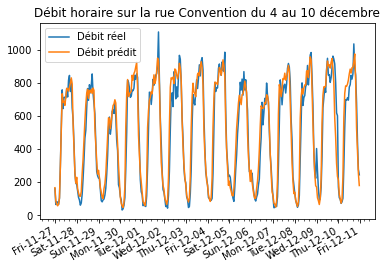

In [51]:
fig, ax = plt.subplots()
plt.title("Débit horaire sur la rue Convention du 4 au 10 décembre")
ax.plot(datetime_last_week, convention_debit_last_week, label="Débit réel")
ax.plot(datetime_last_week, convention_debit_pred, label="Débit prédit")

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_fmt)
ax.xaxis.set_minor_locator(hours)

fig.autofmt_xdate()
plt.legend()
fig.show()

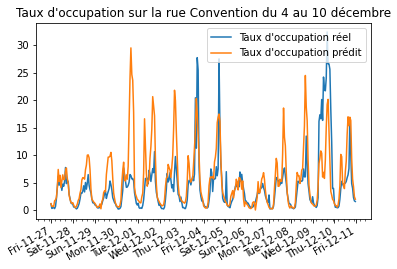

In [52]:
fig, ax = plt.subplots()
plt.title("Taux d'occupation sur la rue Convention du 4 au 10 décembre")
ax.plot(datetime_last_week, convention_occupation_last_week, label="Taux d'occupation réel")
ax.plot(datetime_last_week, convention_occupation_pred, label="Taux d'occupation prédit")

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_fmt)
ax.xaxis.set_minor_locator(hours)

fig.autofmt_xdate()
plt.legend()
fig.show()

## 3. Entrainement des modèles sur toutes les données et prédictions entre le 11 et le 16 décembre

In [53]:
X_convention = data_convention.drop(columns=["Débit horaire", "Taux d'occupation", "datetime", "Date"])
convention_debit = data_convention["Débit horaire"]
convention_occupation = data_convention["Taux d'occupation"]

X_champs = data_champs.drop(columns=["Débit horaire", "Taux d'occupation", "datetime", "Date"])
champs_debit = data_champs["Débit horaire"]
champs_occupation = data_champs["Taux d'occupation"]

X_peres = data_peres.drop(columns=["Débit horaire", "Taux d'occupation", "datetime", "Date"])
peres_debit = data_peres["Débit horaire"]
peres_occupation = data_peres["Taux d'occupation"]

In [54]:
# Entrainement convention
model_convention_debit = XGBRegressor(**debit_convention_params)
model_convention_occupation = XGBRegressor(**occupation_convention_params)

model_convention_debit.fit(X_convention, convention_debit)
model_convention_occupation.fit(X_convention, convention_occupation)

# Entrainement champs
model_champs_debit = XGBRegressor(**debit_champs_params)
model_champs_occupation = XGBRegressor(**occupation_champs_params)

model_champs_debit.fit(X_champs, champs_debit)
model_champs_occupation.fit(X_champs, champs_occupation)

# Entrainement convention
model_peres_debit = XGBRegressor(**debit_peres_params)
model_peres_occupation = XGBRegressor(**occupation_peres_params)

model_peres_debit.fit(X_peres, peres_debit)
model_peres_occupation.fit(X_peres, peres_occupation)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7991046515983015,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.07053987736284192,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.9000376772229515,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
X_prediction = generate_data(datetime(2020,12,11), 6, covid_path, holidays_path, data_folder).iloc[:-1]
datetime_pred = X_prediction["datetime"]
X_prediction = X_prediction.drop(columns=["Date", "datetime"])

In [56]:
X_prediction

,year,month,day,hour,dayofweek,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,StringencyLegacyIndexForDisplay,ContainmentHealthIndexForDisplay,nom_jour_ferie,jour_ferie,nom_vacance_scolaire,vacance_scolaire
0,2020,12,11,0,4,2.0,2.0,2.0,4.0,0.0,2.0,2.0,75.00,74.04,10,0,3,0
1,2020,12,11,1,4,2.0,2.0,2.0,4.0,0.0,2.0,2.0,75.00,74.04,10,0,3,0
2,2020,12,11,2,4,2.0,2.0,2.0,4.0,0.0,2.0,2.0,75.00,74.04,10,0,3,0
3,2020,12,11,3,4,2.0,2.0,2.0,4.0,0.0,2.0,2.0,75.00,74.04,10,0,3,0
4,2020,12,11,4,4,2.0,2.0,2.0,4.0,0.0,2.0,2.0,75.00,74.04,10,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2020,12,16,19,2,1.0,2.0,1.0,4.0,0.0,2.0,0.0,57.86,56.41,10,0,3,0
140,2020,12,16,20,2,1.0,2.0,1.0,4.0,0.0,2.0,0.0,57.86,56.41,10,0,3,0
141,2020,12,16,21,2,1.0,2.0,1.0,4.0,0.0,2.0,0.0,57.86,56.41,10,0,3,0
142,2020,12,16,22,2,1.0,2.0,1.0,4.0,0.0,2.0,0.0,57.86,56.41,10,0,3,0


In [57]:
# Prediction convention
pred_convention_debit = model_convention_debit.predict(X_prediction)
pred_convention_occupation = model_convention_occupation.predict(X_prediction)

# Prediction champs
pred_champs_debit = model_champs_debit.predict(X_prediction)
pred_champs_occupation = model_champs_occupation.predict(X_prediction)

# Prediction peres
pred_peres_debit = model_peres_debit.predict(X_prediction)
pred_peres_occupation = model_peres_occupation.predict(X_prediction)

### Exportation des prédictions

In [58]:
res_convention = pd.DataFrame({
    "Arc": "Convention",
    "Datetime": datetime_pred,
    "Débit horaire": pred_convention_debit,
    "Taux d'occupation": pred_convention_occupation
})
res_champs = pd.DataFrame({
    "Arc": "Champs-Elysées",
    "Datetime": datetime_pred,
    "Débit horaire": pred_champs_debit,
    "Taux d'occupation": pred_champs_occupation
})
res_peres = pd.DataFrame({
    "Arc": "Saint-Pères",
    "Datetime": datetime_pred,
    "Débit horaire": pred_peres_debit,
    "Taux d'occupation": pred_peres_occupation
})
res_peres.head()

,Arc,Datetime,Débit horaire,Taux d'occupation
0,Saint-Pères,2020-12-11 00:00:00,126.911629,1.652441
1,Saint-Pères,2020-12-11 01:00:00,76.936516,0.951865
2,Saint-Pères,2020-12-11 02:00:00,42.623978,0.543656
3,Saint-Pères,2020-12-11 03:00:00,35.709255,0.456315
4,Saint-Pères,2020-12-11 04:00:00,41.591511,0.582732


In [86]:
res_all = pd.concat([res_champs, res_convention, res_peres], ignore_index=True)
res_all.shape

(432, 4)

In [93]:
res_all.to_csv("../data/predictions_latin1.csv", sep=";", index=False, encoding="latin-1")
res_all.to_csv("../data/predictions_utf8.csv", sep=";", index=False)

In [96]:
pd.read_csv("../data/predictions_latin1.csv", sep=";", encoding="latin-1")

,Arc,Datetime,Débit horaire,Taux d'occupation
0,Champs-Elysées,2020-12-11 00:00:00,220.23781,1.632259
1,Champs-Elysées,2020-12-11 01:00:00,197.45874,1.404792
2,Champs-Elysées,2020-12-11 02:00:00,142.15326,1.149456
3,Champs-Elysées,2020-12-11 03:00:00,115.72758,0.778401
4,Champs-Elysées,2020-12-11 04:00:00,110.82727,1.012416
...,...,...,...,...
427,Saint-Pères,2020-12-16 19:00:00,688.85200,9.114010
428,Saint-Pères,2020-12-16 20:00:00,542.16470,4.688209
429,Saint-Pères,2020-12-16 21:00:00,260.05515,2.654254
430,Saint-Pères,2020-12-16 22:00:00,181.27360,2.151692


### Observation des prédictions

No handles with labels found to put in legend.


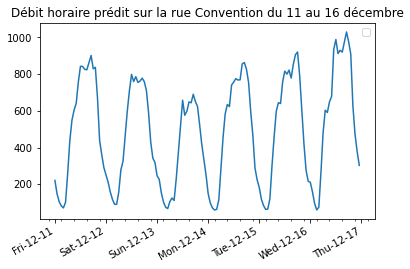

In [60]:
fig, ax = plt.subplots()
plt.title("Débit horaire prédit sur la rue Convention du 11 au 16 décembre")

plt.plot(datetime_pred, pred_convention_debit)

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_fmt)
ax.xaxis.set_minor_locator(hours)

fig.autofmt_xdate()
plt.legend()
fig.show()

No handles with labels found to put in legend.


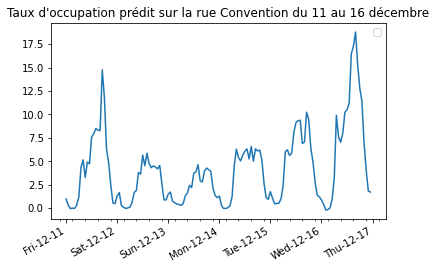

In [61]:
fig, ax = plt.subplots()
plt.title("Taux d'occupation prédit sur la rue Convention du 11 au 16 décembre")

plt.plot(datetime_pred, pred_convention_occupation)

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_fmt)
ax.xaxis.set_minor_locator(hours)

fig.autofmt_xdate()
plt.legend()
fig.show()

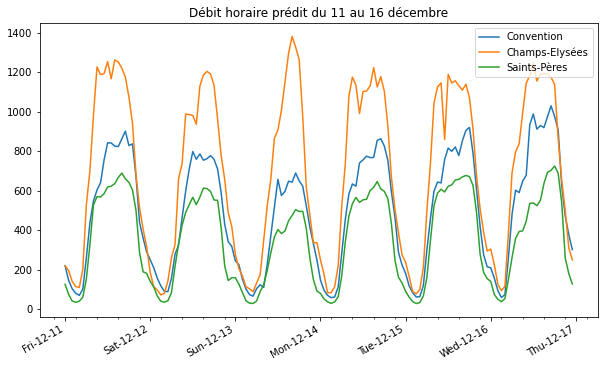

In [64]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Débit horaire prédit du 11 au 16 décembre")

plt.plot(datetime_pred, pred_convention_debit, label="Convention")
plt.plot(datetime_pred, pred_champs_debit, label="Champs-Elysées")
plt.plot(datetime_pred, pred_peres_debit, label="Saints-Pères")

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_fmt)
ax.xaxis.set_minor_locator(hours)

fig.autofmt_xdate()
plt.legend()
fig.show()

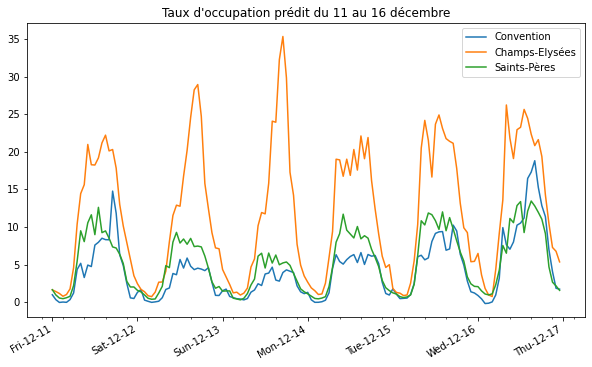

In [65]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Taux d'occupation prédit du 11 au 16 décembre")

plt.plot(datetime_pred, pred_convention_occupation, label="Convention")
plt.plot(datetime_pred, pred_champs_occupation, label="Champs-Elysées")
plt.plot(datetime_pred, pred_peres_occupation, label="Saints-Pères")

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_fmt)
ax.xaxis.set_minor_locator(hours)

fig.autofmt_xdate()
plt.legend()
fig.show()

### Model Explainability

In [66]:
import shap

In [67]:
# exp_convention_debit = shap.TreeExplainer(model_convention_debit)
# shap_convention_debit = exp_convention_debit.shap_values(X_convention)
# exp_convention_occupation = shap.TreeExplainer(model_convention_occupation)
# shap_convention_occupation = exp_convention_occupation.shap_values(X_convention)
# exp_champs_debit = shap.TreeExplainer(model_champs_debit)
# shap_champs_debit = exp_champs_debit.shap_values(X_champs)
# exp_champs_occupation = shap.TreeExplainer(model_champs_occupation)
# shap_champs_occupation = exp_champs_occupation.shap_values(X_champs)
# exp_peres_debit = shap.TreeExplainer(model_peres_debit)
# shap_peres_debit = exp_peres_debit.shap_values(X_peres)
# exp_peres_occupation = shap.TreeExplainer(model_peres_occupation)
# shap_peres_occupation = exp_peres_occupation.shap_values(X_peres)

# Observation de l'efficacité du modèle sur les données antérieures

In [68]:
data_champs.head()

,Débit horaire,Taux d'occupation,datetime,year,month,day,hour,dayofweek,Date,C1_School closing,...,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,StringencyLegacyIndexForDisplay,ContainmentHealthIndexForDisplay,nom_jour_ferie,jour_ferie,nom_vacance_scolaire,vacance_scolaire
0,746.0,10.98889,2019-11-01 03:00:00+00:00,2019,11,1,3,4,2019-11-01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10,1,4,0
1,549.0,7.40722,2019-11-01 04:00:00+00:00,2019,11,1,4,4,2019-11-01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10,1,4,0
2,503.0,7.66667,2019-11-01 05:00:00+00:00,2019,11,1,5,4,2019-11-01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10,1,4,0
3,500.0,4.75500,2019-11-01 06:00:00+00:00,2019,11,1,6,4,2019-11-01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10,1,4,0
4,525.0,5.37389,2019-11-01 07:00:00+00:00,2019,11,1,7,4,2019-11-01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10,1,4,0


In [69]:
semaine_normale_champs_train = (data_champs["datetime"] < "2020-06-08")
semaine_normale_champs = (data_champs["datetime"] >= "2020-06-08") & (data_champs["datetime"] <= "2020-06-15")
datetime_normal = pd.to_datetime(data_champs["datetime"][semaine_normale_champs])

In [70]:
debit_normal_champs = data_champs[semaine_normale_champs]["Débit horaire"]
occupation_normal_champs = data_champs[semaine_normale_champs]["Taux d'occupation"]
X_normal_champs = data_champs[semaine_normale_champs].drop(columns=["datetime", "Date", "Débit horaire", "Taux d'occupation"])
debit_normal_champs_train = data_champs[semaine_normale_champs_train]["Débit horaire"]
occupation_normal_champs_train = data_champs[semaine_normale_champs_train]["Taux d'occupation"]
X_normal_champs_train = data_champs[semaine_normale_champs_train].drop(columns=["datetime", "Date", "Débit horaire", "Taux d'occupation"])

In [71]:
model_normal_champs_debit = XGBRegressor(**debit_champs_params)
model_normal_champs_occupation = XGBRegressor(**occupation_champs_params)
model_normal_champs_debit.fit(X_normal_champs_train, debit_normal_champs_train)
model_normal_champs_occupation.fit(X_normal_champs_train, occupation_normal_champs_train)
pred_debit_normal_champs = model_normal_champs_debit.predict(X_normal_champs)
pred_occupation_normal_champs = model_normal_champs_occupation.predict(X_normal_champs)

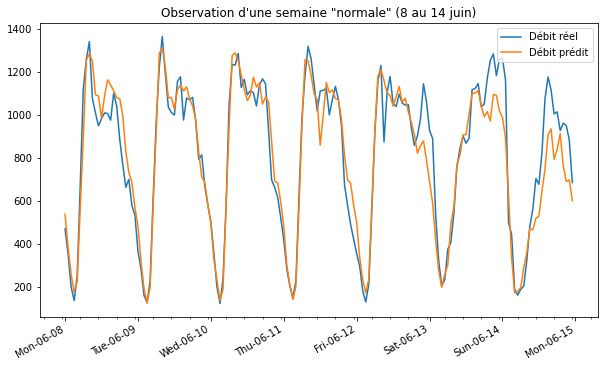

In [72]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Observation d'une semaine \"normale\" (8 au 14 juin)")

plt.plot(datetime_normal, debit_normal_champs, label="Débit réel")
plt.plot(datetime_normal, pred_debit_normal_champs, label="Débit prédit")

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_fmt)
ax.xaxis.set_minor_locator(hours)

fig.autofmt_xdate()
plt.legend()
fig.show()

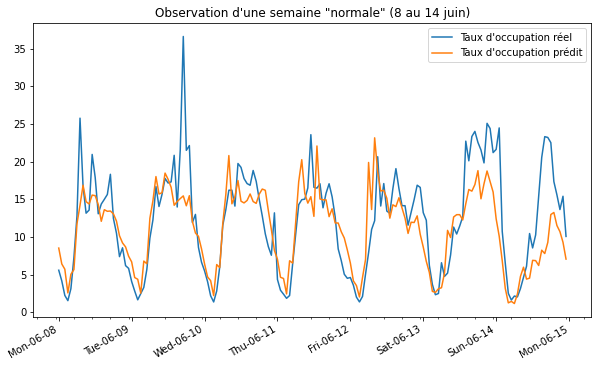

In [73]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Observation d'une semaine \"normale\" (8 au 14 juin)")

plt.plot(datetime_normal, occupation_normal_champs, label="Taux d'occupation réel")
plt.plot(datetime_normal, pred_occupation_normal_champs, label="Taux d'occupation prédit")

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_fmt)
ax.xaxis.set_minor_locator(hours)

fig.autofmt_xdate()
plt.legend()
fig.show()

In [74]:
semaine_couvre_feu_champs_train = (data_champs["datetime"] < "2020-10-19")
semaine_couvre_feu_champs = (data_champs["datetime"] >= "2020-10-19") & (data_champs["datetime"] <= "2020-10-26")
datetime_couvre_feu = pd.to_datetime(data_champs["datetime"][semaine_couvre_feu_champs])

In [75]:
debit_couvre_feu_champs = data_champs[semaine_couvre_feu_champs]["Débit horaire"]
occupation_couvre_feu_champs = data_champs[semaine_couvre_feu_champs]["Taux d'occupation"]
X_couvre_feu_champs = data_champs[semaine_couvre_feu_champs].drop(columns=["datetime", "Date", "Débit horaire", "Taux d'occupation"])
debit_couvre_feu_champs_train = data_champs[semaine_couvre_feu_champs_train]["Débit horaire"]
occupation_couvre_feu_champs_train = data_champs[semaine_couvre_feu_champs_train]["Taux d'occupation"]
X_couvre_feu_champs_train = data_champs[semaine_couvre_feu_champs_train].drop(columns=["datetime", "Date", "Débit horaire", "Taux d'occupation"])

In [76]:
model_couvre_feu_champs_debit = XGBRegressor(**debit_champs_params)
model_couvre_feu_champs_occupation = XGBRegressor(**occupation_champs_params)
model_couvre_feu_champs_debit.fit(X_couvre_feu_champs_train, debit_couvre_feu_champs_train)
model_couvre_feu_champs_occupation.fit(X_couvre_feu_champs_train, occupation_couvre_feu_champs_train)
pred_debit_couvre_feu_champs = model_couvre_feu_champs_debit.predict(X_couvre_feu_champs)
pred_occupation_couvre_feu_champs = model_couvre_feu_champs_occupation.predict(X_couvre_feu_champs)

In [77]:
X_couvre_feu_champs_sans_covid = X_couvre_feu_champs.drop(columns=['C1_School closing',
        'C2_Workplace closing', 'C3_Cancel public events',
        'C4_Restrictions on gatherings', 'C5_Close public transport',
        'C6_Stay at home requirements',
        'C7_Restrictions on internal movement', 'StringencyLegacyIndexForDisplay',
        'ContainmentHealthIndexForDisplay',])
X_couvre_feu_champs_sans_covid_train = X_couvre_feu_champs_train.drop(columns=['C1_School closing',
        'C2_Workplace closing', 'C3_Cancel public events',
        'C4_Restrictions on gatherings', 'C5_Close public transport',
        'C6_Stay at home requirements',
        'C7_Restrictions on internal movement', 'StringencyLegacyIndexForDisplay',
        'ContainmentHealthIndexForDisplay',])
model_sans_covid_couvre_feu_champs_debit = XGBRegressor(**debit_champs_params)
model_sans_covid_couvre_feu_champs_occupation = XGBRegressor(**occupation_champs_params)
model_sans_covid_couvre_feu_champs_debit.fit(X_couvre_feu_champs_sans_covid_train, debit_couvre_feu_champs_train)
model_sans_covid_couvre_feu_champs_occupation.fit(X_couvre_feu_champs_sans_covid_train, occupation_couvre_feu_champs_train)
pred_sans_covid_debit_couvre_feu_champs = model_sans_covid_couvre_feu_champs_debit.predict(X_couvre_feu_champs_sans_covid)
pred_sans_covid_occupation_couvre_feu_champs = model_sans_covid_couvre_feu_champs_occupation.predict(X_couvre_feu_champs_sans_covid)

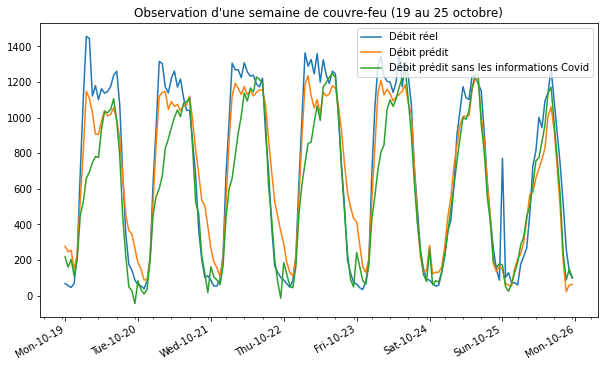

In [78]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Observation d'une semaine de couvre-feu (19 au 25 octobre)")

plt.plot(datetime_couvre_feu, debit_couvre_feu_champs, label="Débit réel")
plt.plot(datetime_couvre_feu, pred_debit_couvre_feu_champs, label="Débit prédit")
plt.plot(datetime_couvre_feu, pred_sans_covid_debit_couvre_feu_champs, label="Débit prédit sans les informations Covid")

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_fmt)
ax.xaxis.set_minor_locator(hours)

fig.autofmt_xdate()
plt.legend()
fig.show()

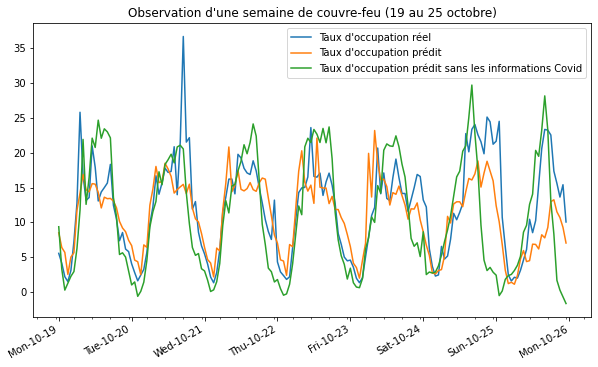

In [79]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Observation d'une semaine de couvre-feu (19 au 25 octobre)")

plt.plot(datetime_couvre_feu, occupation_normal_champs, label="Taux d'occupation réel")
plt.plot(datetime_couvre_feu, pred_occupation_normal_champs, label="Taux d'occupation prédit")
plt.plot(datetime_couvre_feu, pred_sans_covid_occupation_couvre_feu_champs, label="Taux d'occupation prédit sans les informations Covid")

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_fmt)
ax.xaxis.set_minor_locator(hours)

fig.autofmt_xdate()
plt.legend()
fig.show()

In [80]:
semaine_confinement_champs_train = (data_champs["datetime"] < "2020-11-23")
semaine_confinement_champs = (data_champs["datetime"] >= "2020-11-23") & (data_champs["datetime"] <= "2020-11-30")
datetime_confinement = pd.to_datetime(data_champs["datetime"][semaine_confinement_champs])

In [81]:
debit_confinement_champs = data_champs[semaine_confinement_champs]["Débit horaire"]
occupation_confinement_champs = data_champs[semaine_confinement_champs]["Taux d'occupation"]
X_confinement_champs = data_champs[semaine_confinement_champs].drop(columns=["datetime", "Date", "Débit horaire", "Taux d'occupation"])
debit_confinement_champs_train = data_champs[semaine_confinement_champs_train]["Débit horaire"]
occupation_confinement_champs_train = data_champs[semaine_confinement_champs_train]["Taux d'occupation"]
X_confinement_champs_train = data_champs[semaine_confinement_champs_train].drop(columns=["datetime", "Date", "Débit horaire", "Taux d'occupation"])

In [82]:
model_confinement_champs_debit = XGBRegressor(**debit_champs_params)
model_confinement_champs_occupation = XGBRegressor(**occupation_champs_params)
model_confinement_champs_debit.fit(X_confinement_champs_train, debit_confinement_champs_train)
model_confinement_champs_occupation.fit(X_confinement_champs_train, occupation_confinement_champs_train)
pred_debit_confinement_champs = model_confinement_champs_debit.predict(X_confinement_champs)
pred_occupation_confinement_champs = model_confinement_champs_occupation.predict(X_confinement_champs)

In [83]:
X_confinement_champs_sans_covid = X_confinement_champs.drop(columns=['C1_School closing',
        'C2_Workplace closing', 'C3_Cancel public events',
        'C4_Restrictions on gatherings', 'C5_Close public transport',
        'C6_Stay at home requirements',
        'C7_Restrictions on internal movement', 'StringencyLegacyIndexForDisplay',
        'ContainmentHealthIndexForDisplay',])
X_confinement_champs_sans_covid_train = X_confinement_champs_train.drop(columns=['C1_School closing',
        'C2_Workplace closing', 'C3_Cancel public events',
        'C4_Restrictions on gatherings', 'C5_Close public transport',
        'C6_Stay at home requirements',
        'C7_Restrictions on internal movement', 'StringencyLegacyIndexForDisplay',
        'ContainmentHealthIndexForDisplay',])
model_sans_covid_confinement_champs_debit = XGBRegressor(**debit_champs_params)
model_sans_covid_confinement_champs_occupation = XGBRegressor(**occupation_champs_params)
model_sans_covid_confinement_champs_debit.fit(X_confinement_champs_sans_covid_train, debit_confinement_champs_train)
model_sans_covid_confinement_champs_occupation.fit(X_confinement_champs_sans_covid_train, occupation_confinement_champs_train)
pred_sans_covid_debit_confinement_champs = model_sans_covid_confinement_champs_debit.predict(X_confinement_champs_sans_covid)
pred_sans_covid_occupation_confinement_champs = model_sans_covid_confinement_champs_occupation.predict(X_confinement_champs_sans_covid)

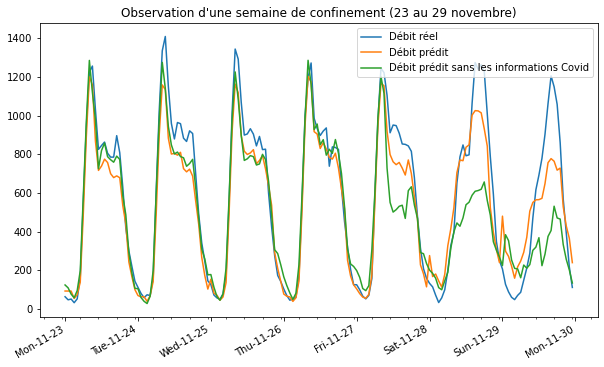

In [84]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Observation d'une semaine de confinement (23 au 29 novembre)")

plt.plot(datetime_confinement, debit_confinement_champs, label="Débit réel")
plt.plot(datetime_confinement, pred_debit_confinement_champs, label="Débit prédit")
plt.plot(datetime_confinement, pred_sans_covid_debit_confinement_champs, label="Débit prédit sans les informations Covid")

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_fmt)
ax.xaxis.set_minor_locator(hours)

fig.autofmt_xdate()
plt.legend()
fig.show()

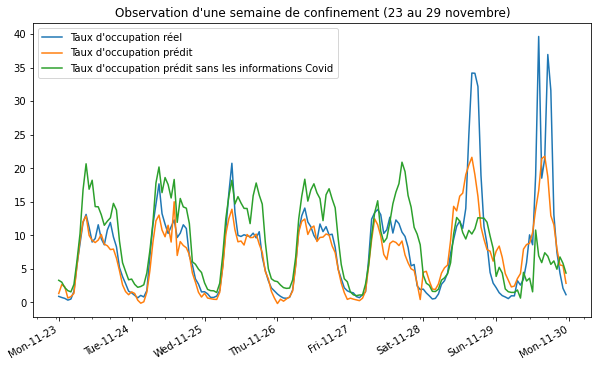

In [85]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Observation d'une semaine de confinement (23 au 29 novembre)")

plt.plot(datetime_confinement, occupation_confinement_champs, label="Taux d'occupation réel")
plt.plot(datetime_confinement, pred_occupation_confinement_champs, label="Taux d'occupation prédit")
plt.plot(datetime_confinement, pred_sans_covid_occupation_confinement_champs, label="Taux d'occupation prédit sans les informations Covid")

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_fmt)
ax.xaxis.set_minor_locator(hours)

fig.autofmt_xdate()
plt.legend()
fig.show()